In [176]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scienceplots
from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable
from scipy.optimize import curve_fit
from scipy.special import gamma
plt.style.use(["science","bright","grid"])

cm  = plt.get_cmap('cividis')
ma  = ["o","s","^","v","<",">"]

## DC Input - Voltage Distribution - Closed Circuit

In [177]:
def shift_and_append(dfs_dict):
    for name, df in dfs_dict.items():
        col1 = df.pop("1")  # remove column 1
        df.columns = range(df.shape[1])  # reassign column names to keep them sequential
        df[len(df.columns)] = col1  # append column 1's data at the end
    return dfs_dict


# Parameter
folder      = "/home/j/j_mens07/phd/data/2_funding_period/current/wo_magic_cable/dc_input_vs_size/"
N_voltages  = 50000
t_vals      = np.arange(N_voltages-1)*1e-10*1e9
N_vals      = [10,12,14,16,18,20,22,24,26,28,30,32,34,36,38,40] # + [42,44,46,48,50,52,54,56,58,60,62,64,66,68,70,72,74,76,78,80]

# Potentials
U_0_vals    = [pd.read_csv(f"{folder}Nx={N_p}_Ny=1_Ne=2.csv").loc[0,'E0'] for N_p in N_vals]
pot         = {N_p : pd.read_csv(f"{folder}mean_state_Nx={N_p}_Ny=1_Ne=2.csv") for N_p in N_vals}
pot         = shift_and_append(pot)
pot_eq      = pd.DataFrame([pot[N_p].iloc[45000:,:].mean().values / U_0_vals[i] for i, N_p in enumerate(N_vals)],index=N_vals).T.round(2)

# Output Current
out_curr    = {N_p : pd.read_csv(f"{folder}Nx={N_p}_Ny=1_Ne=2.csv")['Observable'].values*1e-9 for N_p in N_vals}

### Steady State

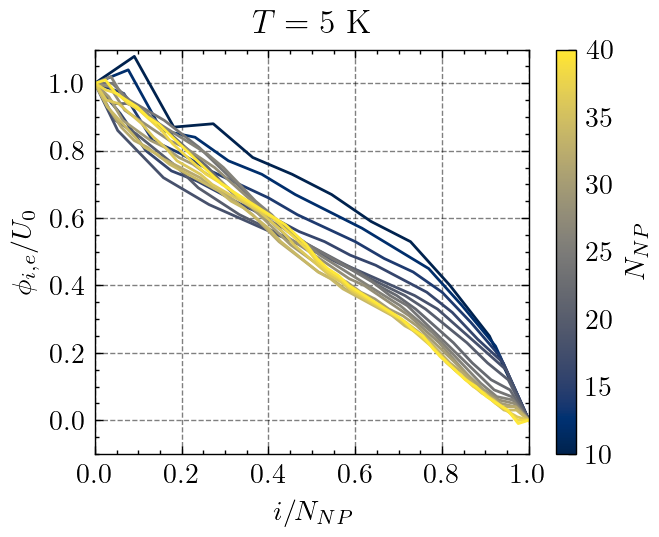

In [178]:
fig     = plt.figure(dpi=200)
ax      = fig.add_subplot()
norm    = Normalize(vmin=min(N_vals), vmax=max(N_vals))

for i, N in enumerate(N_vals):

    p   = pot_eq[N].dropna().values.copy()
    x   = np.linspace(0,1,len(p))
    ax.plot(x, p, color=cm(norm(N)))

ax.set_title(f"$T = 5$ K")
ax.set_ylim(-0.1,1.1)
ax.set_xlim(0,1)
ax.set_ylabel("$\phi_{i,e} / U_0$")
ax.set_xlabel("$i / N_{NP}$")

sm  = ScalarMappable(cmap=cm, norm=norm)
sm.set_array([])
cbar = fig.colorbar(sm, ax=ax)
cbar.set_label("$N_{NP}$")

fig.savefig("../plots/dc_input/nonlinear/closed_circuit_node_potential.svg", transparent=True)

There are three distinct regions:
- Alternating Pattern (First NPs)
  - Electrons tunneling into the string repel each other, creating **oscillatory potentials**
  - Example:
    - NP0 charges to $\phi_0 \approx U_0$
    - NP1 receives an electron, lowering $\phi_1$ slightly compared to $\phi_0$
    - NP2 then sees a reduced bias, leading to $\phi_2 > \phi_1$
  - **Standing charge wave**, where single-electron hops create local potential minima/maxima
- Quasi-Linear Decay (Middle NPs)
  - ***Averaging over many charge hops***
    - As charges propagate, the discreteness effects smear out, resembling a linear response but at **quanized steps**
    - The slope $d\phi / dk$ reflects the **effective resistance** per NP
- Rapid Drop (Last NPs)
  - The grounded electrode strongly attracts electrons, accelerating the drop in $\phi_k$
  - Charges near the end tunnel more frequently due to the larger $\Delta \phi$

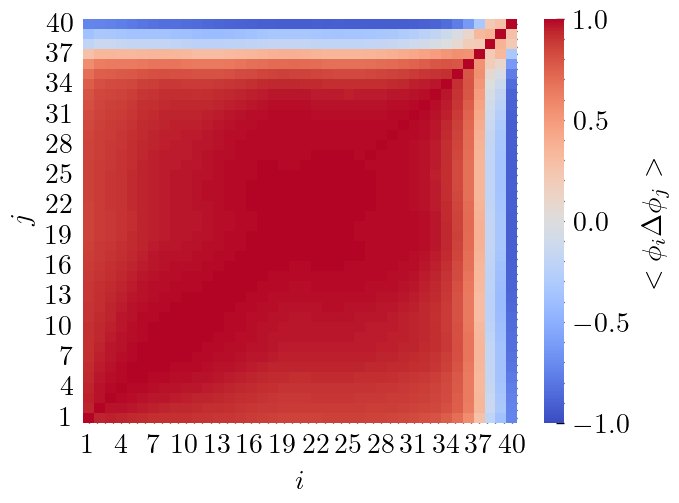

In [179]:
Np  = 40
fig = plt.figure(dpi=200)
ax  = fig.add_subplot()
ax  = sns.heatmap(pot[Np].iloc[:,1:-1].corr(), cmap='coolwarm', vmin=-1, vmax=1, ax=ax,
                  cbar_kws={"label":"$<\phi_{i}\Delta\phi_{j}>$"})
ax.set_xlabel("$i$")
ax.set_ylabel("$j$")
ax.invert_yaxis()
plt.yticks(rotation=0) 

fig.savefig("../plots/dc_input/nonlinear/closed_circuit_node_pot_corr.svg", transparent=True)

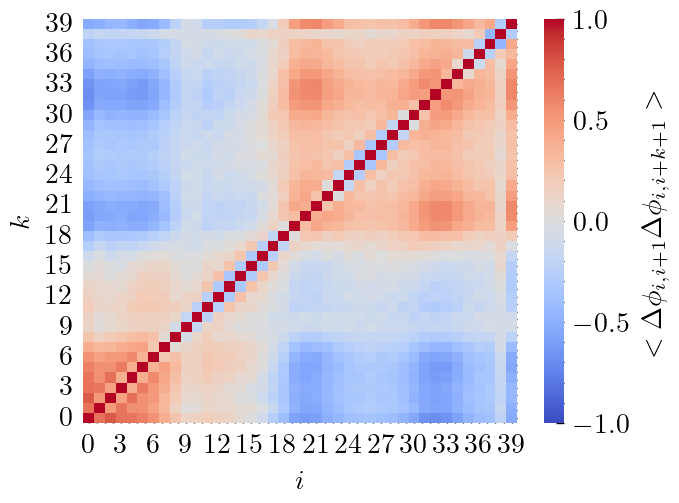

In [180]:
Np      = 40
p_diff  = pot[Np].diff(axis=1).iloc[:,1:-1].values
delta_p = pd.DataFrame(p_diff)

fig = plt.figure(dpi=200)
ax  = fig.add_subplot()
ax  = sns.heatmap(delta_p.corr(), cmap='coolwarm', vmin=-1, vmax=1, ax=ax,
                  cbar_kws={"label":"$<\Delta\phi_{i,i+1}\Delta\phi_{i,i+k+1}>$"})
ax.set_xlabel("$i$")
ax.set_ylabel("$k$")
ax.invert_yaxis()
plt.yticks(rotation=0) 

fig.savefig("../plots/dc_input/nonlinear/closed_circuit_node_pot_diff_corr.svg", transparent=True)

- Alternating correlation signals local charge-density waves:
  - Electrons repel each other, creating a quasi-ordered pattern
  - Perfect order (Wigner crystallization) is disturbed due to thermal fluctuations and finite bias given $U_0$
- As the grounded electrode drains charges, we get enhancing correlations in the last few NPs

## Fitting the relaxation process

In [144]:
def smooth_potential(potential_array, window_size=51):
    """Applies a centered moving average filter to smooth out simulation noise."""
    if window_size % 2 == 0:
        window_size += 1
    potential_series = pd.Series(potential_array)
    smoothed_series = potential_series.rolling(window=window_size, center=True).mean()
    smoothed_series = smoothed_series.bfill().ffill()
    return smoothed_series.to_numpy()

(0.0, 500.0)

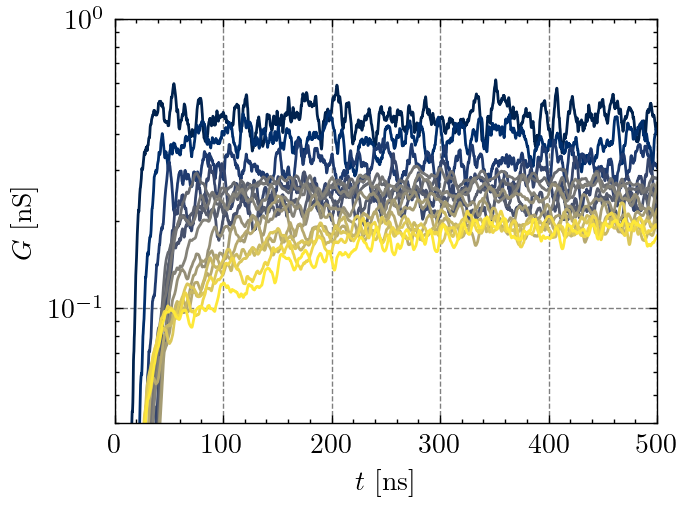

In [149]:
fig, ax = plt.subplots(dpi=200)
norm    = Normalize(vmin=N_vals[0], vmax=N_vals[-1])

for i, Np in enumerate(N_vals):
    ax.plot(t_vals, smooth_potential(out_curr[Np]/U_0_vals[i],51), color=cm(norm(Np)))

ax.set_yscale('log')
ax.set_xlabel("$t$ [ns]")
ax.set_ylabel("$G$ [nS]")
ax.set_ylim(0.04,1)
ax.set_xlim(0,500)

In [165]:
p_vals, cov_vals = {}, {}
p0, p1 = 0.5, 0.9
for i, Np in enumerate(N_vals):
    x       = t_vals.copy()
    y       = smooth_potential(out_curr[Np]/U_0_vals[i],51)
    y_max   = np.mean(y[-10000:])
    def func(t, tau, a0):
        return y_max - a0*np.exp(-t/tau)
        
    t0      = np.argmax(y>p0*y_max)
    t1      = np.argmax(y>p1*y_max)
    x_fit   = x.copy()[t0:t1]
    y_fit   = y.copy()[t0:t1]
    try:
        p, cov  = curve_fit(func, x_fit, y_fit, p0=[20,y_max], bounds=((0,0),(np.inf,np.inf)))
    except:
        p = np.array([np.nan,np.nan])
        c = np.array([[np.nan,np.nan],[np.nan,np.nan]])
    p_vals[Np] = p
    cov_vals[Np] = cov

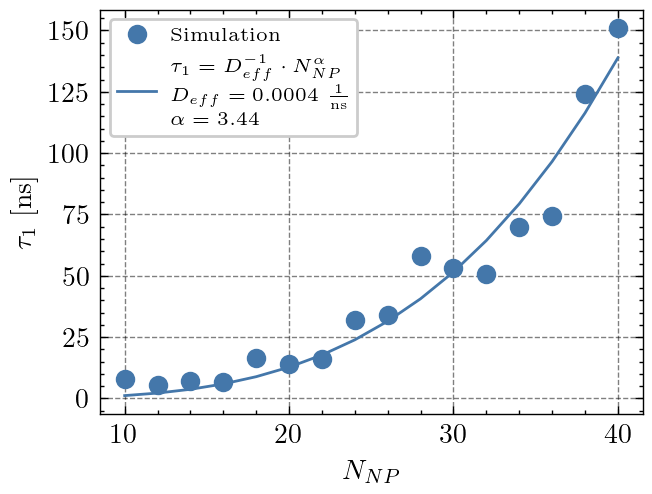

In [169]:
tau_current = np.array([p[0] for _, p in p_vals.items()])

def quad_func(x, a, b):
    return a*x**b

fig = plt.figure(dpi=200)
ax  = fig.add_subplot()
p,c = curve_fit(quad_func, N_vals, tau_current, check_finite=False)
pp  = ax.plot(N_vals, tau_current, 'o', label='Simulation')
ax.plot(N_vals, quad_func(np.array(N_vals), *p), color=pp[0].get_color(),
        label="$\\tau_1 = D_{eff}^{-1} \cdot N_{NP}^\\alpha$\n\
        $D_{eff} = "+f"{np.round(p[0],4)}$"+" $\\frac{1}{\\text{ns}}$\n"+f"\
        $\\alpha = {np.round(p[1],2)}$")

ax.set_ylabel("$\\tau_1$ [ns]")
ax.set_xlabel("$N_{NP}$")
ax.legend(fontsize='x-small', loc='upper left')

# fig.savefig("../plots/dc_input/linear/closed_circuit_time_scales_vs_N.svg", transparent=True)

In [18]:
def smooth_potential(potential_array, window_size=51):
    """Applies a centered moving average filter to smooth out simulation noise."""
    if window_size % 2 == 0:
        window_size += 1
    potential_series = pd.Series(potential_array)
    smoothed_series = potential_series.rolling(window=window_size, center=True).mean()
    smoothed_series = smoothed_series.bfill().ffill()
    return smoothed_series.to_numpy()


def calculate_settling_time(time_array, potential_array, settling_band_fraction=0.10, 
                                    required_consecutive_points=20, eq_points_fraction=0.3):
    """
    Calculates the settling time by finding the FIRST time the signal enters
    and STAYS within a symmetric percentage band for a required number of points.

    This version is robust for non-monotonic signals with overshoots and dips.

    Args:
        time_array (np.ndarray): The array of time values.
        potential_array (np.ndarray): The array of potential values (ideally smoothed).
        settling_band_fraction (float, optional): The half-width of the acceptance
                                                 band. Defaults to 0.10 (for T90, i.e., +/- 10%).
        required_consecutive_points (int, optional): The number of consecutive
                                                    data points the signal must
                                                    remain inside the band.
        eq_points_fraction (float, optional): Fraction of final data points
                                              to use for determining equilibrium.

    Returns:
        float: The settling time. Returns np.nan if the signal never settles.
    """
    t = np.asarray(time_array)
    y = np.asarray(potential_array)
    n = required_consecutive_points

    # 1. Determine the equilibrium value from the tail of the data
    num_eq_points = max(20, int(len(y) * eq_points_fraction))
    if len(y) < num_eq_points: return np.nan
    y_eq = np.mean(y[-num_eq_points:])

    if np.isclose(y_eq, 0): return np.nan
    
    # --- THIS IS THE CORRECTED LOGIC ---
    # 2. Define the two-sided acceptance band
    band_half_width = settling_band_fraction * y_eq
    lower_bound = y_eq - band_half_width
    upper_bound = y_eq + band_half_width

    # 3. Create a boolean array: True if inside the band, False otherwise.
    is_inside = (y >= lower_bound) & (y <= upper_bound)
    # ------------------------------------

    # 4. Iterate to find the first stable sequence of 'n' points inside the band
    for i in range(len(is_inside) - n + 1):
        if np.all(is_inside[i : i+n]):
            # Found the start of the first stable period.
            return t[i]

    # 5. If the loop finishes, no such stable sequence was found.
    return np.nan

In [42]:
p_vals, cov_vals = {}, {}
p0, p1 = 0.8, 0.9
for Np in N_vals:
    p_tmp, cov_tmp = [], []
    for k in range(1,Np+1):

        x       = t_vals.copy()
        y       = pot[Np].loc[:,k].values
        y_max   = np.mean(y[-10000:])
        def func(t, tau, a0):
            return y_max - a0*np.exp(-t/tau)
        
        t0      = np.argmax(y>p0*y_max)
        t1      = np.argmax(y>p1*y_max)
        x_fit   = x.copy()[t0:t1]
        y_fit   = y.copy()[t0:t1]
        try:
            p, cov  = curve_fit(func, x_fit, y_fit, p0=[20,y_max], bounds=((0,0),(np.inf,np.inf)))
        except:
            p   = np.array([np.nan,np.nan])
            cov = np.array([[np.nan,np.nan],[np.nan,np.nan]])
        p_tmp.append(p)
        cov_tmp.append(cov)
    p_vals[Np] = np.array(p_tmp)
    cov_vals[Np] = np.array(cov_tmp)

/tmp/ipykernel_3960/2560225528.py:18: OptimizeWarning: Covariance of the parameters could not be estimated
  p, cov  = curve_fit(func, x_fit, y_fit, p0=[20,y_max], bounds=((0,0),(np.inf,np.inf)))


(0.0, 5000.0)

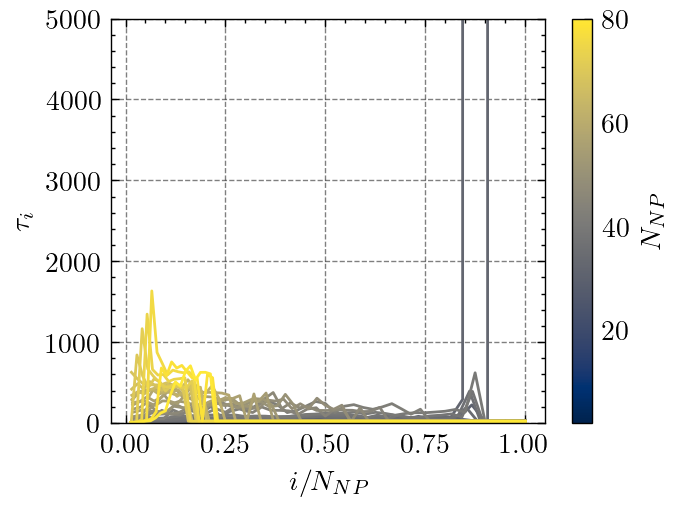

In [43]:
norm = Normalize(vmin=N_vals[0], vmax=N_vals[-1])

fig = plt.figure(dpi=200)
ax  = fig.add_subplot()
for Np in N_vals:
    ax.plot(np.arange(1,Np+1)/Np, p_vals[Np][:,0], color=cm(norm(Np)))

sm  = ScalarMappable(cmap=cm, norm=norm)
sm.set_array([])
cbar = fig.colorbar(sm, ax=ax)
cbar.set_label("$N_{NP}$")

ax.set_ylabel("$\\tau_i$")
ax.set_xlabel("$i/N_{NP}$")
ax.set_ylim(0,5000)

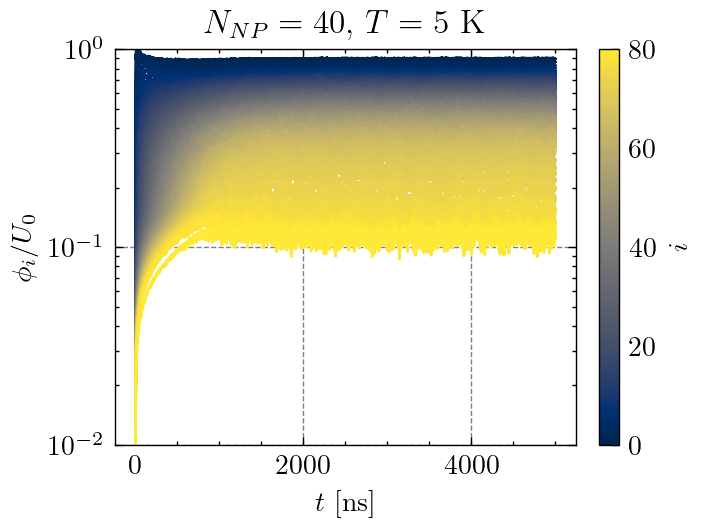

In [45]:
fig     = plt.figure(dpi=200, layout='constrained')
ax      = fig.add_subplot()
Np      = 80
i_U0    = np.where(np.array(N_vals)==Np)[0][0]
U_0     = U_0_vals[i_U0]
norm    = Normalize(vmin=0, vmax=Np)

for i in range(1,Np+1):
    ax.plot(t_vals, pot[Np][i].values/U_0, color=cm(norm(i)))

ax.set_title("$N_{NP} = 40$, $T = 5$ K")
# ax.set_xlim(0,500)
ax.set_ylim(0.01,1)
ax.set_yscale('log')
ax.set_ylabel("$\phi_i / U_0$")
ax.set_xlabel("$t$ [ns]")

sm  = ScalarMappable(cmap=cm, norm=norm)
sm.set_array([])
cbar = fig.colorbar(sm, ax=ax)
cbar.set_label("$i$")

fig.savefig("../plots/dc_input/nonlinear/closed_circuit_node_time_series.svg", transparent=True)

In [610]:
t_95_vals = {}
for i, Np in enumerate(N_vals):
    t_95 = []
    for k in range(1,Np+1):
        y = pot[Np][k].values
        # t_95.append(calculate_settling_time(t_vals, smooth_potential(y/U_0_vals[i],51), settling_band_fraction=0.1, required_consecutive_points=200))
        t_95.append(calculate_settling_time(t_vals, y/U_0_vals[i], settling_band_fraction=0.05, required_consecutive_points=50))
    t_95_vals[Np] = t_95

Text(0.5, 0, '$i/N_{NP}$')

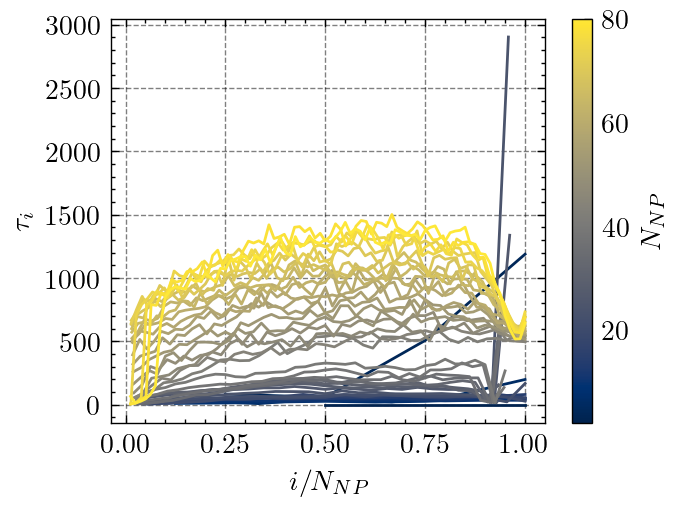

In [612]:
norm = Normalize(vmin=N_vals[0], vmax=N_vals[-1])

fig = plt.figure(dpi=200)
ax  = fig.add_subplot()
for Np in N_vals:
    ax.plot(np.arange(1,Np+1)/Np, t_95_vals[Np], color=cm(norm(Np)))

sm  = ScalarMappable(cmap=cm, norm=norm)
sm.set_array([])
cbar = fig.colorbar(sm, ax=ax)
cbar.set_label("$N_{NP}$")

ax.set_ylabel("$\\tau_i$")
ax.set_xlabel("$i/N_{NP}$")
# ax.set_ylim(0,400)

In [613]:
def extract_plateau_value(data_array, exclusion_fraction=0.2, window_size=10):
    """
    Finds the most stable plateau in a data series and returns its mean value.

    The algorithm excludes the start and end of the data to avoid boundary
    effects, then uses a sliding window to find the region with the lowest
    coefficient of variation (std/mean).

    Args:
        data_array (np.ndarray): The 1D array of data (e.g., T90 for each node).
        exclusion_fraction (float, optional): The fraction of data to exclude from
                                              each end. Defaults to 0.25 (25%).
        window_size (int, optional): The number of points in the sliding window
                                     used to find the flattest region.

    Returns:
        float: The mean value of the most stable plateau region.
               Returns np.nan if the data is not sufficient.
    """
    # 1. Remove any NaN values from the input
    valid_data = data_array[~np.isnan(data_array)]
    
    if len(valid_data) < window_size:
        return np.nan # Not enough data to analyze

    # 2. Define the search region by excluding the ends
    n_total = len(valid_data)
    start_idx = int(n_total * exclusion_fraction)
    end_idx = int(n_total * (1.0 - exclusion_fraction))
    
    search_data = valid_data[start_idx:end_idx]

    if len(search_data) < window_size:
        # If exclusion leaves too few points, search the whole valid data
        search_data = valid_data
        if len(search_data) < window_size:
            return np.nan

    # 3. Use a sliding window to find the most stable region (lowest CV)
    min_cv = np.inf
    best_mean = np.nan
    best_window_indices = None

    for i in range(len(search_data) - window_size + 1):
        window = search_data[i : i + window_size]
        
        mean = np.mean(window)
        std = np.std(window)

        if np.isclose(mean, 0): continue # Avoid division by zero

        cv = std / mean
        if cv < min_cv:
            min_cv = cv
            best_mean = mean
            # Store the global indices of this window for plotting
            best_window_indices = range(start_idx + i, start_idx + i + window_size)

    # For plotting/debugging purposes, we can return the indices as well
    # For now, let's just return the value.
    return best_mean

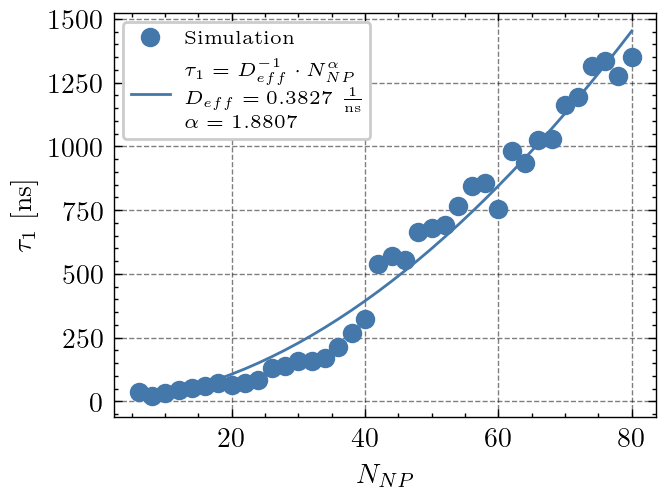

In [615]:
N_range     = np.array(N_vals).copy()
p_bound     = 0.1
tau_np      = np.array([extract_plateau_value(np.array(t_95_vals[Np]),exclusion_fraction=p_bound,window_size=5) for Np in N_range])

def quad_func(x, a, b):
    return a*x**b

fig = plt.figure(dpi=200)
ax  = fig.add_subplot()
p,c = curve_fit(quad_func, N_range[np.isfinite(tau_np)], tau_np[np.isfinite(tau_np)])
pp  = ax.plot(N_range[np.isfinite(tau_np)], tau_np[np.isfinite(tau_np)], 'o', label='Simulation')
ax.plot(N_range[np.isfinite(tau_np)], quad_func(np.array(N_range)[np.isfinite(tau_np)], *p), color=pp[0].get_color(),
        label="$\\tau_1 = D_{eff}^{-1} \cdot N_{NP}^\\alpha$\n$D_{eff} = "+f"{np.round(p[0],4)}$"+" $\\frac{1}{\\text{ns}}$\n$\\alpha = "+f"{np.round(p[1],4)}$")

ax.set_ylabel("$\\tau_1$ [ns]")
# ax.set_xlim(1,41)
ax.set_xlabel("$N_{NP}$")
ax.legend(fontsize='x-small', loc='upper left')

# fig.savefig("../plots/dc_input/nonlinear/closed_circuit_time_scales_vs_N.svg", transparent=True)

Text(0.5, 0, '$t$ [ns]')

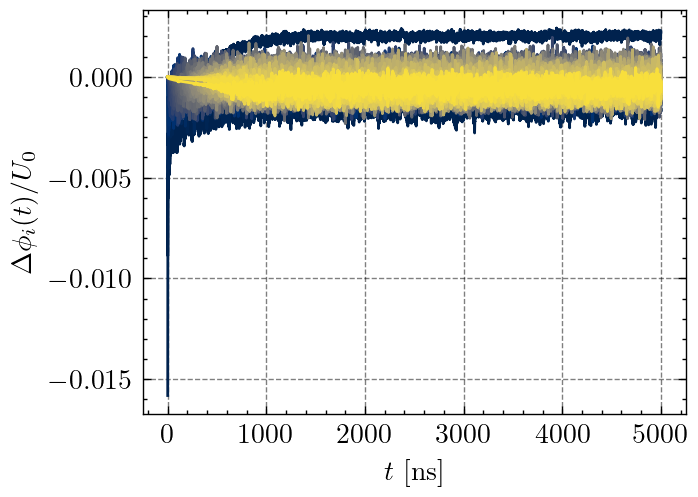

In [635]:
Np      = 60
p_diff  = pot[Np].diff(axis=1).drop(columns=0).values
fig     = plt.figure(dpi=200)
ax      = fig.add_subplot()
for i in range(Np):
    ax.plot(t_vals, p_diff[:,i], color=cm((i-1)/Np), label=f'${i}$')
# ax.set_xlim(-1,400)
ax.set_ylabel("$\Delta \phi_i(t) / U_0$")
ax.set_xlabel("$t$ [ns]")
# ax.legend(fontsize='x-small', ncol=2)

## Electric Current

## DC Input - Voltage Distribution - Open Circuit

In [181]:
def shift_and_append(dfs_dict):
    for name, df in dfs_dict.items():
        col1 = df.pop("1")  # remove column 1
        df.columns = range(df.shape[1])  # reassign column names to keep them sequential
        df[len(df.columns)] = col1  # append column 1's data at the end
    return dfs_dict


# Parameter
folder      = "/home/j/j_mens07/phd/data/2_funding_period/potential/wo_magic_cable/dc_input_vs_size/"
N_voltages  = 50000
t_vals      = np.arange(N_voltages-1)*1e-10*1e9
N_vals      = [2,4,6,8,10,12,14,16,18,20,22,24,26,28,30,32,34,36,38,40] #+ [42,44,46,48,50,52,54,56,58,60,62,64,66,68,70,72,74,76,78,80]

# Potentials
U_0_vals    = [pd.read_csv(f"{folder}Nx={N_p}_Ny=1_Ne=2.csv").loc[0,'E0'] for N_p in N_vals]
pot         = {N_p : pd.read_csv(f"{folder}mean_state_Nx={N_p}_Ny=1_Ne=2.csv") for N_p in N_vals}
pot         = shift_and_append(pot)
pot_eq      = pd.DataFrame([pot[N_p].iloc[45000:,:].mean().values / U_0_vals[i] for i, N_p in enumerate(N_vals)],index=N_vals).T.round(2)

# Output Current
out_curr    = {N_p : pd.read_csv(f"{folder}Nx={N_p}_Ny=1_Ne=2.csv")['Observable'].values for N_p in N_vals}

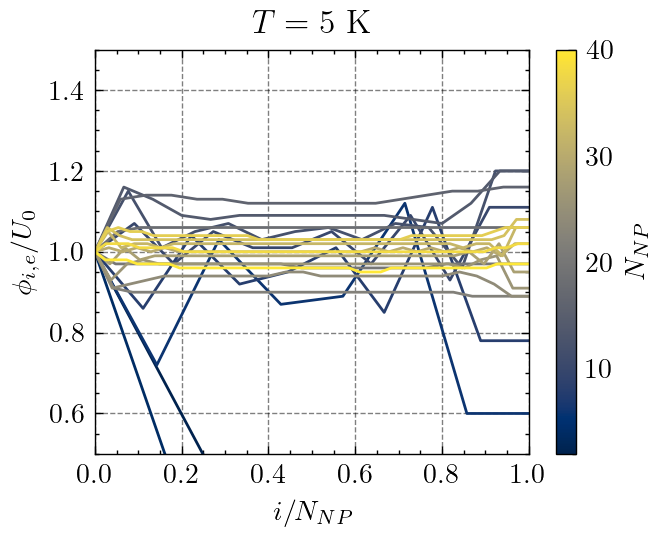

In [182]:
fig     = plt.figure(dpi=200)
ax      = fig.add_subplot()
norm    = Normalize(vmin=min(N_vals), vmax=max(N_vals))

for i, N in enumerate(N_vals):

    p   = pot_eq[N].dropna().values.copy()
    x   = np.linspace(0,1,len(p))
    ax.plot(x, p, color=cm(norm(N)))

ax.set_title(f"$T = 5$ K")
ax.set_ylim(0.5,1.5)
ax.set_xlim(0,1)
ax.set_ylabel("$\phi_{i,e} / U_0$")
ax.set_xlabel("$i / N_{NP}$")

sm  = ScalarMappable(cmap=cm, norm=norm)
sm.set_array([])
cbar = fig.colorbar(sm, ax=ax)
cbar.set_label("$N_{NP}$")

fig.savefig("../plots/dc_input/nonlinear/open_circuit_node_potential.svg", transparent=True)

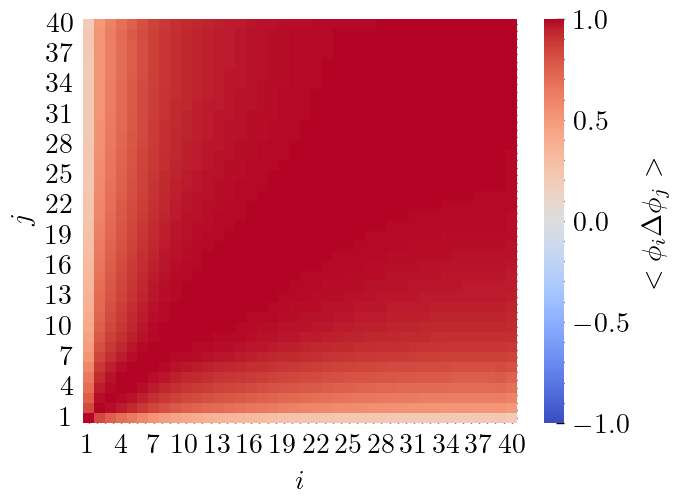

In [183]:
Np  = 40
fig = plt.figure(dpi=200)
ax  = fig.add_subplot()
ax  = sns.heatmap(pot[Np].iloc[:,1:-1].corr(), cmap='coolwarm', vmin=-1, vmax=1, ax=ax,
                  cbar_kws={"label":"$<\phi_{i}\Delta\phi_{j}>$"})
ax.set_xlabel("$i$")
ax.set_ylabel("$j$")
ax.invert_yaxis()
plt.yticks(rotation=0) 

fig.savefig("../plots/dc_input/nonlinear/open_circuit_node_pot_corr.svg", transparent=True)

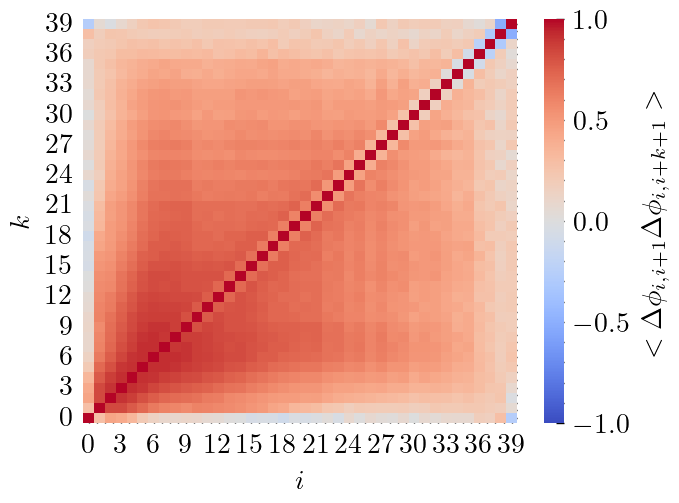

In [184]:
Np      = 40
p_diff  = pot[Np].diff(axis=1).iloc[:,1:-1].values
delta_p = pd.DataFrame(p_diff)

fig = plt.figure(dpi=200)
ax  = fig.add_subplot()
ax  = sns.heatmap(delta_p.corr(), cmap='coolwarm', vmin=-1, vmax=1, ax=ax,
                  cbar_kws={"label":"$<\Delta\phi_{i,i+1}\Delta\phi_{i,i+k+1}>$"})
ax.set_xlabel("$i$")
ax.set_ylabel("$k$")
ax.invert_yaxis()
plt.yticks(rotation=0) 

fig.savefig("../plots/dc_input/nonlinear/open_circuit_node_pot_diff_corr.svg", transparent=True)

(0.0, 500.0)

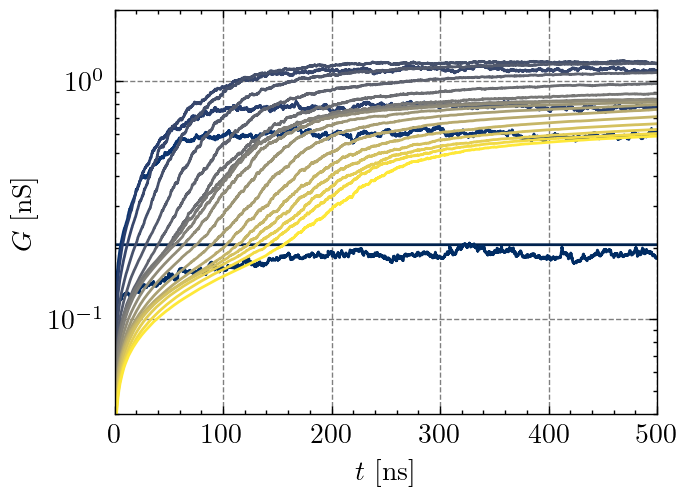

In [188]:
fig, ax = plt.subplots(dpi=200)
norm    = Normalize(vmin=N_vals[0], vmax=N_vals[-1])

for i, Np in enumerate(N_vals):
    ax.plot(t_vals, out_curr[Np]/U_0_vals[i], color=cm(norm(Np)))

ax.set_yscale('log')
ax.set_xlabel("$t$ [ns]")
ax.set_ylabel("$G$ [nS]")
ax.set_ylim(0.04,2)
ax.set_xlim(0,500)

In [193]:
p_vals, cov_vals = {}, {}
p0, p1 = 0.5, 0.9
for i, Np in enumerate(N_vals):
    x       = t_vals.copy()
    y       = smooth_potential(out_curr[Np]/U_0_vals[i],51)
    y_max   = np.mean(y[-10000:])
    def func(t, tau, a0):
        return y_max - a0*np.exp(-t/tau)
        
    t0      = np.argmax(y>p0*y_max)
    t1      = np.argmax(y>p1*y_max)
    x_fit   = x.copy()[t0:t1]
    y_fit   = y.copy()[t0:t1]
    try:
        p, cov  = curve_fit(func, x_fit, y_fit, p0=[20,y_max], bounds=((0,0),(np.inf,np.inf)))
    except:
        p = np.array([np.nan,np.nan])
        c = np.array([[np.nan,np.nan],[np.nan,np.nan]])
    p_vals[Np] = p
    cov_vals[Np] = cov

/tmp/ipykernel_3960/1298842633.py:8: OptimizeWarning: Covariance of the parameters could not be estimated
  p,c = curve_fit(quad_func, N_vals, tau_current, check_finite=False)


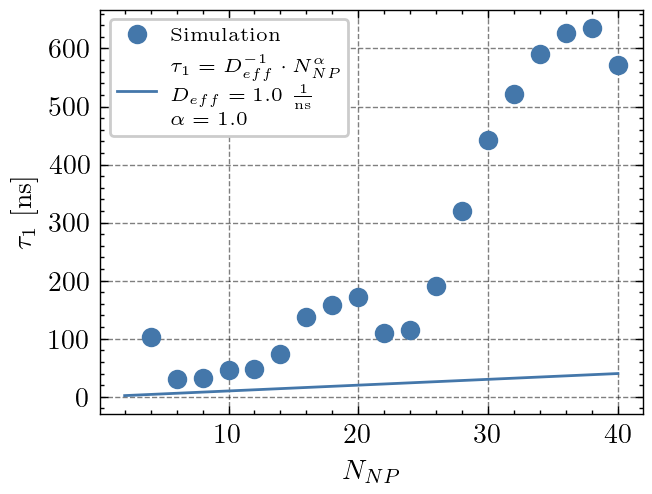

In [194]:
tau_current = np.array([p[0] for _, p in p_vals.items()])

def quad_func(x, a, b):
    return a*x**b

fig = plt.figure(dpi=200)
ax  = fig.add_subplot()
p,c = curve_fit(quad_func, N_vals, tau_current, check_finite=False)
pp  = ax.plot(N_vals, tau_current, 'o', label='Simulation')
ax.plot(N_vals, quad_func(np.array(N_vals), *p), color=pp[0].get_color(),
        label="$\\tau_1 = D_{eff}^{-1} \cdot N_{NP}^\\alpha$\n\
        $D_{eff} = "+f"{np.round(p[0],4)}$"+" $\\frac{1}{\\text{ns}}$\n"+f"\
        $\\alpha = {np.round(p[1],2)}$")

ax.set_ylabel("$\\tau_1$ [ns]")
ax.set_xlabel("$N_{NP}$")
ax.legend(fontsize='x-small', loc='upper left')

# fig.savefig("../plots/dc_input/linear/closed_circuit_time_scales_vs_N.svg", transparent=True)

In [195]:
p_vals, cov_vals = {}, {}
p0, p1 = 0.8, 0.9
for Np in N_vals:
    p_tmp, cov_tmp = [], []
    for k in range(1,Np+1):

        x       = t_vals.copy()
        y       = pot[Np].loc[:,k].values
        y_max   = np.mean(y[-10000:])
        def func(t, tau, a0):
            return y_max - a0*np.exp(-t/tau)
        
        t0      = np.argmax(y>p0*y_max)
        t1      = np.argmax(y>p1*y_max)
        x_fit   = x.copy()[t0:t1]
        y_fit   = y.copy()[t0:t1]
        try:
            p, cov  = curve_fit(func, x_fit, y_fit, p0=[20,y_max], bounds=((0,0),(np.inf,np.inf)))
        except:
            p   = np.array([np.nan,np.nan])
            cov = np.array([[np.nan,np.nan],[np.nan,np.nan]])
        p_tmp.append(p)
        cov_tmp.append(cov)
    p_vals[Np] = np.array(p_tmp)
    cov_vals[Np] = np.array(cov_tmp)

(0.0, 5000.0)

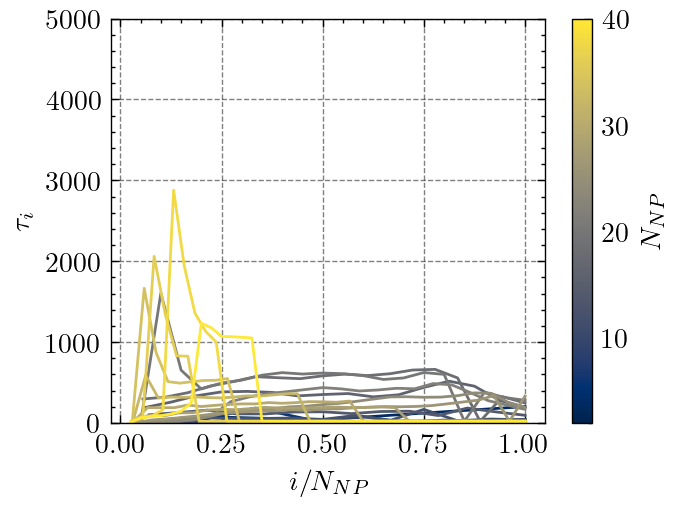

In [196]:
norm = Normalize(vmin=N_vals[0], vmax=N_vals[-1])

fig = plt.figure(dpi=200)
ax  = fig.add_subplot()
for Np in N_vals:
    ax.plot(np.arange(1,Np+1)/Np, p_vals[Np][:,0], color=cm(norm(Np)))

sm  = ScalarMappable(cmap=cm, norm=norm)
sm.set_array([])
cbar = fig.colorbar(sm, ax=ax)
cbar.set_label("$N_{NP}$")

ax.set_ylabel("$\\tau_i$")
ax.set_xlabel("$i/N_{NP}$")
ax.set_ylim(0,5000)

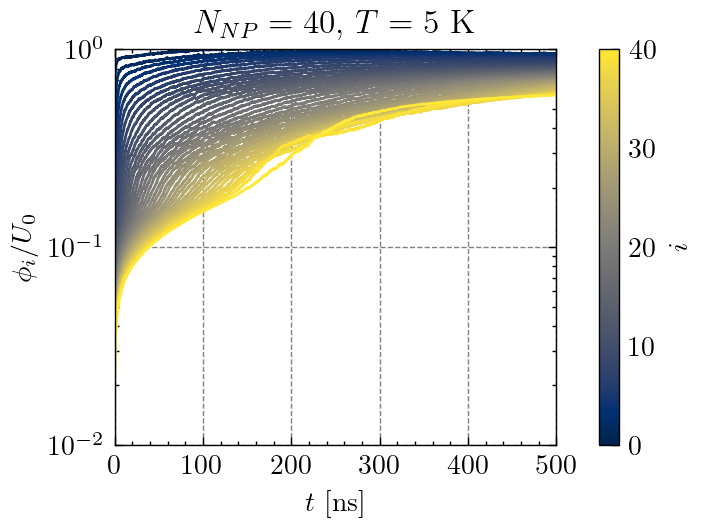

In [197]:
fig     = plt.figure(dpi=200, layout='constrained')
ax      = fig.add_subplot()
Np      = 40
i_U0    = np.where(np.array(N_vals)==Np)[0][0]
U_0     = U_0_vals[i_U0]
norm    = Normalize(vmin=0, vmax=Np)

for i in range(1,Np+1):
    ax.plot(t_vals, pot[Np][i].values/U_0, color=cm(norm(i)))

ax.set_title("$N_{NP} = 40$, $T = 5$ K")
ax.set_xlim(0,500)
ax.set_ylim(0.01,1)
ax.set_yscale('log')
ax.set_ylabel("$\phi_i / U_0$")
ax.set_xlabel("$t$ [ns]")

sm  = ScalarMappable(cmap=cm, norm=norm)
sm.set_array([])
cbar = fig.colorbar(sm, ax=ax)
cbar.set_label("$i$")

fig.savefig("../plots/dc_input/nonlinear/open_circuit_node_time_series.svg", transparent=True)

In [198]:
t_95_vals = {}
for i, Np in enumerate(N_vals):
    t_95 = []
    for k in range(1,Np+1):
        y = pot[Np][k].values
        # t_95.append(calculate_settling_time(t_vals, smooth_potential(y/U_0_vals[i],51), settling_band_fraction=0.1, required_consecutive_points=200))
        t_95.append(calculate_settling_time(t_vals, y/U_0_vals[i], settling_band_fraction=0.05, required_consecutive_points=50))
    t_95_vals[Np] = t_95

Text(0.5, 0, '$i/N_{NP}$')

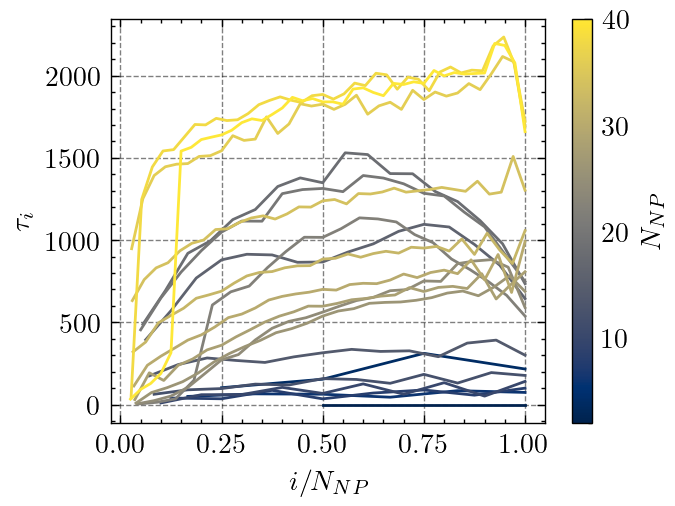

In [199]:
norm = Normalize(vmin=N_vals[0], vmax=N_vals[-1])

fig = plt.figure(dpi=200)
ax  = fig.add_subplot()
for Np in N_vals:
    ax.plot(np.arange(1,Np+1)/Np, t_95_vals[Np], color=cm(norm(Np)))

sm  = ScalarMappable(cmap=cm, norm=norm)
sm.set_array([])
cbar = fig.colorbar(sm, ax=ax)
cbar.set_label("$N_{NP}$")

ax.set_ylabel("$\\tau_i$")
ax.set_xlabel("$i/N_{NP}$")
# ax.set_ylim(0,400)

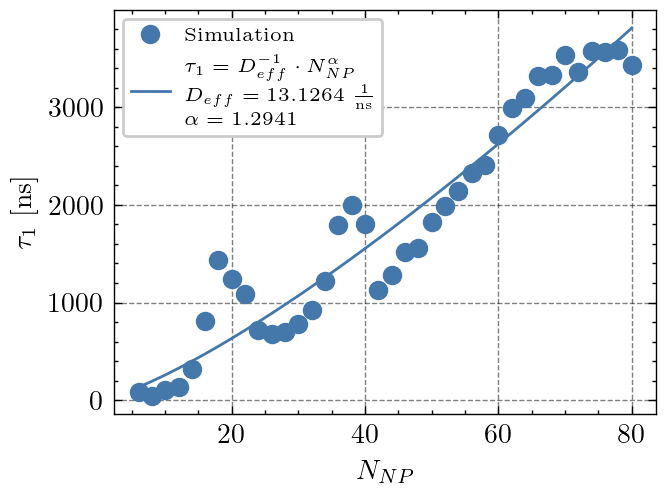

In [677]:
N_range     = np.array(N_vals).copy()
p_bound     = 0.1
tau_np      = np.array([extract_plateau_value(np.array(t_95_vals[Np]),exclusion_fraction=p_bound,window_size=5) for Np in N_range])

def quad_func(x, a, b):
    return a*x**b

fig = plt.figure(dpi=200)
ax  = fig.add_subplot()
p,c = curve_fit(quad_func, N_range[np.isfinite(tau_np)], tau_np[np.isfinite(tau_np)])
pp  = ax.plot(N_range[np.isfinite(tau_np)], tau_np[np.isfinite(tau_np)], 'o', label='Simulation')
ax.plot(N_range[np.isfinite(tau_np)], quad_func(np.array(N_range)[np.isfinite(tau_np)], *p), color=pp[0].get_color(),
        label="$\\tau_1 = D_{eff}^{-1} \cdot N_{NP}^\\alpha$\n$D_{eff} = "+f"{np.round(p[0],4)}$"+" $\\frac{1}{\\text{ns}}$\n$\\alpha = "+f"{np.round(p[1],4)}$")

ax.set_ylabel("$\\tau_1$ [ns]")
# ax.set_xlim(1,41)
ax.set_xlabel("$N_{NP}$")
ax.legend(fontsize='x-small', loc='upper left')

# fig.savefig("../plots/dc_input/nonlinear/closed_circuit_time_scales_vs_N.svg", transparent=True)

Text(0.5, 0, '$t$ [ns]')

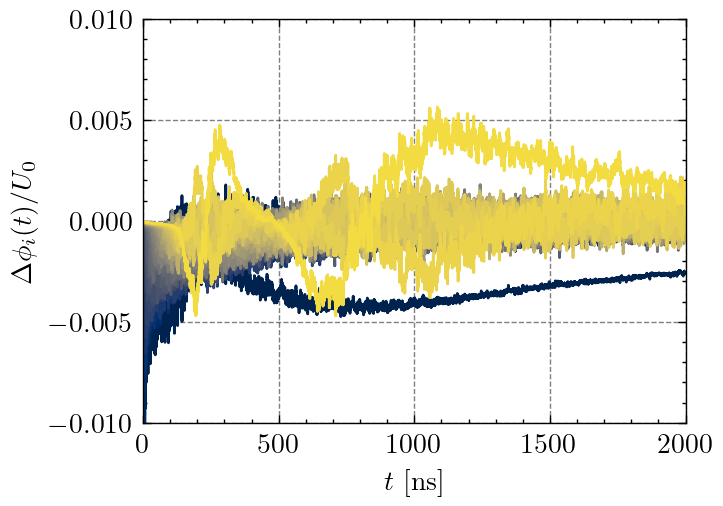

In [681]:
Np      = 40
p_diff  = pot[Np].diff(axis=1).drop(columns=0).values
fig     = plt.figure(dpi=200)
ax      = fig.add_subplot()
for i in range(Np):
    ax.plot(t_vals, p_diff[:,i], color=cm((i-1)/Np), label=f'${i}$')
ax.set_xlim(0,2000)
ax.set_ylim(-0.01,0.01)
ax.set_ylabel("$\Delta \phi_i(t) / U_0$")
ax.set_xlabel("$t$ [ns]")
# ax.legend(fontsize='x-small', ncol=2)

### Outdated

In [182]:
Np  = 40
Q_t = np.zeros_like(pot[Np].values)
C   = cap_matrix[Np]
C_i = inv_cap_matrix[Np]
for t in range(pot[Np].values.shape[0]):
    Q_t[t, :] = C @ pot[Np].values[t, :]

# Total injected charge (relative to t=0)
Q_total = np.sum(Q_t - Q_t[0, :], axis=1)  # Shape: (N_T,)
P       = Q_t[-1, 1:] - Q_t[-1, :-1]

E_t = np.zeros(pot[Np].values.shape[0])
for t in range(pot[Np].values.shape[0]):
    E_t[t] = 0.5 * Q_t[t, :].T @ C_i @ Q_t[t, :]

Text(0, 0.5, '$P_i$')

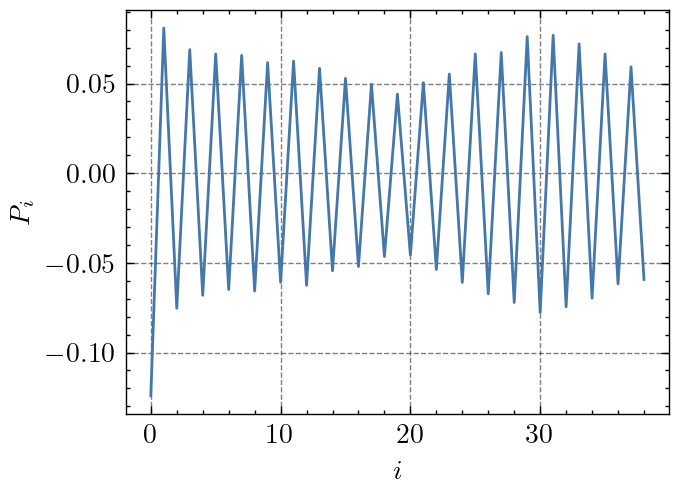

In [185]:
fig = plt.figure(dpi=200)
ax  = fig.add_subplot()
ax.plot(P)
ax.set_xlabel("$i$")
ax.set_ylabel("$P_i$")

Text(0, 0.5, '$Q_{total}$ [C]')

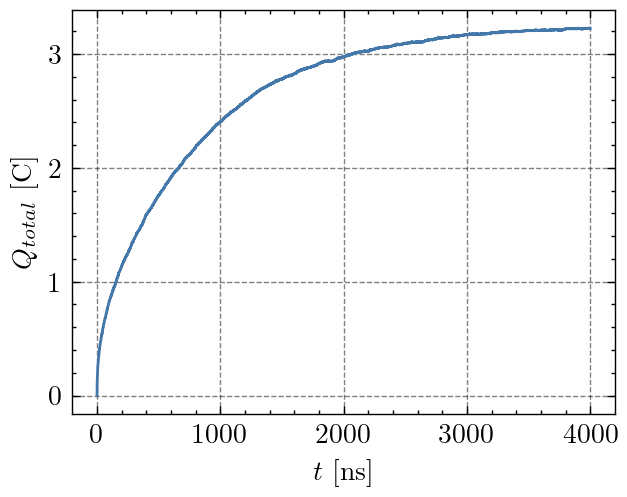

In [192]:
fig = plt.figure(dpi=200)
ax  = fig.add_subplot()
ax.plot(t_vals,Q_total)
ax.set_xlabel("$t$ [ns]")
ax.set_ylabel("$Q_{total}$ [C]")

Text(0, 0.5, '$E$ [J]')

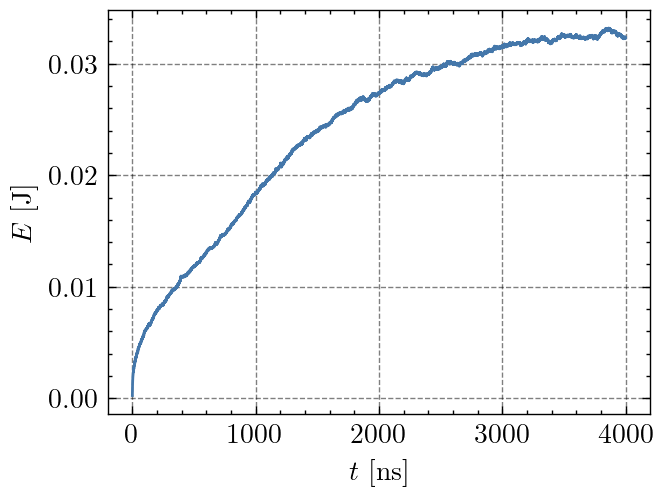

In [193]:
fig = plt.figure(dpi=200)
ax  = fig.add_subplot()
ax.plot(t_vals,E_t)
ax.set_xlabel("$t$ [ns]")
ax.set_ylabel("$E$ [J]")

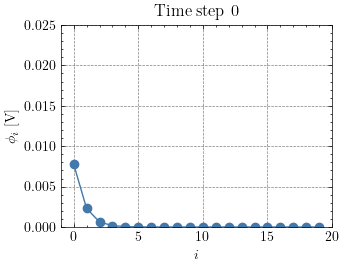

In [207]:
Np      = 20
p_anni  = pot[Np].values.copy()[:5000,:]
fig, ax = plt.subplots()
ax.set_xlabel('$i$')
ax.set_ylabel('$\phi_i$ [V]')
ax.set_ylim(np.min(pot[Np].values), np.max(pot[Np].values))
ax.set_xlim(-1, Np)
line, = ax.plot([], [], 'o-')

def update(frame):
    line.set_data(np.arange(Np), pot[Np].values[frame, :])
    ax.set_title(f'Time step {frame}')
    return line,

ani = FuncAnimation(fig, update, frames=pot[Np].values.shape[0], interval=10, blit=True)

In [ ]:
ani.save("test.gif")

MovieWriter ffmpeg unavailable; using Pillow instead.


---